### Testing Hyperbolic Discounting

I implement hyperbolic discounting by modyfing the `solveOneCycle` function in `core.py`. If a `geometric_solution` attribute is specified, the `solveOneCycle` function uses the solutions specified in this attribute list in its backward induction loop, instead of the current solution. The exponential discount factor is also resized by a factor of the `hyperbolic` discount variable. 

In [9]:
from __future__ import division
import os
os.chdir("/Users/gcarranza/repo/gcarranza-HARK")

import numpy as np
from HARK.ConsumptionSaving import ConsumerParameters as Params
from HARK.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType
from HARK.utilities import plotFuncsDer, plotFuncs

from copy import copy, deepcopy
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import warnings; warnings.simplefilter('ignore')

We want to test if this implementation of HARK for hyperbolic agents is accurate. We check the results using a simple 3 period consumption model with Perfect Foresight, for which we have simple algebraic solutions we can use to corroborate our results. The consumption functions have a linear closed form expression, outlined in `quasi_hyperbolic_algebra.pdf`. The slope of the consumption functions are functions of $\beta$ and $\delta$ for both the exponential and hyperbolic cases. We solve first for the exponential case. 

#### Exponential Case

In [10]:
PFexample = PerfForesightConsumerType(**Params.init_perfect_foresight)
PFexample.CRRA = 1.0000000001 # Using a logarithmic utility function
PFexample.cycles = 1 
PFexample.T_cycle = 3
PFexample.T_age = 3
PFexample.Rfree = 1
PFexample.PermGroFac = [1, 1, 1]
PFexample.LivPrb = [1, 1, 1]
PFexample.aNrmInitStd  = 0.0000000000000000000000000000000001

In [11]:
PFexample.DiscFac = 0.9
PFexample.solve()
PFexample.unpackcFunc()
print("Plot of Consumption Functions")
for T in range(3):
    x = np.linspace(0,10, 1000,endpoint=True)
    y = PFexample.cFunc[T+1](x)
    plt.plot(x,y, label = T+1)
plt.xlim([0, 10])
plt.legend(title='Period')
plt.show()

AttributeError: 'PerfForesightConsumerType' object has no attribute 'hyperbolic'

According to `quasi_hyperbolic_algebra`:

$$C_3=X_{3}$$

$$C_{2}=\frac{1}{1+\delta}X_{2}+\frac{1}{1+\delta}$$

$$C_{1}= \frac{1}{1+\delta+\delta^2}X_{1}+\frac{2}{1+\delta^2+\delta^3}$$

Checking if the slopes match the polynomial expressions:

In [4]:
print(PFexample.cFunc[3].derivative(1))
print(PFexample.cFunc[2].derivative(1))
print(PFexample.cFunc[1].derivative(1))

1.0
0.5263157894710575
0.36900369003328515


In [5]:
print(1/np.polyval([1],0.9))
print(1/np.polyval([1,1],0.9))
print(1/np.polyval([1,1,1],0.9))

1.0
0.5263157894736842
0.36900369003690037


They do.

#### Hyperbolic Case

We set a `hyperbolic` factor of 0.7 and assign the previous generated consumption functions as `geometric_solution`.

Plot of Consumption Functions


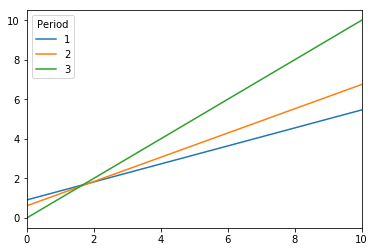

In [6]:
geom_solution = deepcopy(PFexample.solution)
PFexample_hyperbolic = deepcopy(PFexample)
PFexample_hyperbolic.geometric_solution = geom_solution
PFexample_hyperbolic.hyperbolic=0.7
PFexample_hyperbolic.solve()
PFexample_hyperbolic.unpackcFunc()
print("Plot of Consumption Functions")
for T in range(3):
    x = np.linspace(0,10, 1000,endpoint=True)
    y = PFexample_hyperbolic.cFunc[T+1](x)
    plt.plot(x,y, label = T+1)
plt.xlim([0, 10])
plt.legend(title='Period')
plt.show()

According to `quasi_hyperbolic_algebra`:

$$C_3=X_{3}$$

$$C_{2}=\frac{1}{1+\beta\delta}X_{2}+\frac{1}{1+\beta\delta}$$

$$C_{1}= \frac{1}{1+\beta\delta+\beta\delta^2}X_{1}+\frac{2}{1+\beta\delta^2+\beta\delta^3}$$

Checking if the slopes match the polynomial expressions:

In [7]:
print(PFexample_hyperbolic.cFunc[3].derivative(1))
print(PFexample_hyperbolic.cFunc[2].derivative(1))
print(PFexample_hyperbolic.cFunc[1].derivative(1))

1.0
0.6134969325043818
0.4551661356268127


In [8]:
print(1/np.polyval([1],0.9))
print(1/np.polyval([0.7,1],0.9))
print(1/np.polyval([0.7,0.7,1],0.9))

1.0
0.6134969325153374
0.4551661356395084


The same slopes are found.